# Determine Food Item's Food Processing Levels 
# using NOVA Nutrient Profilling System
# with Fine-Tuned BERT model (classification task)

<img src="./n.png" alt="alt text" style="height: 300px">

https://nutrition.org/using-the-nova-classification-system-to-identify-and-estimate-intake-of-ultraprocessed-foods/


# import packages

In [ ]:
# package for fine tune
import numpy as np
import pandas as pd
import transformers
from datasets import Dataset, load_metric, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,mean_squared_error,r2_score,accuracy_score,balanced_accuracy_score,roc_curve,auc,f1_score
from sklearn.metrics import precision_recall_fscore_support, log_loss
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
transformers.logging.set_verbosity_error()

In [ ]:
# package for performance specifically
from sklearn.metrics import classification_report
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from tensorflow.python.ops.numpy_ops import np_config
plt.rcParams['figure.dpi'] = 200
sns.set(rc={'figure.figsize':(4,4)},style='ticks',font="Arial", font_scale=1)
from itertools import cycle

# import OpenFoodFact data

In [ ]:
dfOFF = pd.read_csv("/Users/hgl/Dropbox/545_Group_Project/545_Group_project_shared/data/food_fact_withUnhealthScore.csv",header=0)
# transform nutrients' units
dfOFF['KCAL'] = dfOFF['energy']/4.18
dfOFF['NAsodium'] = dfOFF['sodium']*1000
dfOFF.columns
dfOFF #ingredients_text

/var/folders/6l/n964dwrj0ys303n336mlx0k40000gn/T/ipykernel_69368/2482673141.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dfOFF = pd.read_csv("/Users/hgl/Dropbox/545_Group_Project/545_Group_project_shared/data/food_fact_withUnhealthScore.csv",header=0)


,Unnamed: 0,code,product_name,brands,country,ingredients_text,additives,nutrition_grade_fr,energy,fat,...,fiber,proteins,salt,sodium,nutrition-score-fr,serving_size_numeric,serving_size_units,KCAL,NAsodium,FSANZ-hgl
0,67,32117,Tricolor Tortellini,Napoleon,United States,"Egg pasta (refined durum semolina wheat flour,...",0.0,c,1611.0,9.23,...,3.1,13.85,1.13284,0.446000,7.0,65.0,g,385.406699,446.000000,-4.089640
1,72,33060,10-Grain Pancake Mix,Bob's Red Mill,United States,"Wheat, rye, triticale, oat, corn, barley, soy ...",2.0,c,1297.0,1.72,...,6.9,13.79,2.75844,1.086000,9.0,58.0,g,310.287081,1086.000000,-8.053166
2,175,69601,Fresh Organic Carrots,Bunny-Luv,United States,Fresh organic carrots,0.0,a,159.0,0.00,...,2.6,1.28,0.19558,0.077000,-2.0,78.0,g,38.038278,77.000000,-9.774875
3,176,290616,Salade Cesar,Kirkland Signature,Canada,INGREDIENTS : LAITUE. VINAIGRETTE (HUILE DE CA...,0.0,c,1210.0,12.00,...,2.0,22.00,2.16000,0.850000,6.0,100.0,g,289.473684,850.000000,1.966481
4,182,1938067,Chaussons tressés aux pommes,Kirkland Signature,Canada,"Ingrédients : Pâte (farine, margarines d'huile...",5.0,c,1090.0,10.70,...,2.0,3.33,0.64700,0.255000,9.0,150.0,g,260.765550,255.000000,4.214868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105180,355883,95656335,Chipotle Peppers In Adobo Sauce,La Costena,United States,"Chipotle peppers, water, vinegar, tomatoes, on...",0.0,c,280.0,0.00,...,10.0,0.00,3.21818,1.267000,6.0,30.0,g,66.985646,1267.000000,-13.900986
105181,355884,95659305,Dal Makhani,Truly Indian,United States,"Tomato, black gram, water, milk cream, cottons...",0.0,b,502.0,5.33,...,2.0,4.67,1.37160,0.540000,2.0,150.0,g,120.095694,540.000000,-6.750500
105182,355888,9577283844672,100% Pur Jus 4 agrumes,Cora,France,"Jus d'orange (dont pulpe 1,6%), jus de clément...",0.0,c,192.0,0.50,...,0.6,0.60,0.03000,0.011811,4.0,200.0,ml,45.933014,11.811024,-3.312844
105183,355985,9787461062105,Natural Cassava,Industria De Casabe Paul,United States,Cassava.,0.0,a,1477.0,0.00,...,4.7,1.18,0.03048,0.012000,-1.0,85.0,g,353.349282,12.000000,-3.944408


# import training data

In [ ]:
dfFLIP = pd.read_csv("C:/Users/huguanla/Dropbox/FLIP_cleaned_All_ID_202411_hgl_ok.csv",header=0) # labelled training data
df2017 = dfFLIP.loc[dfFLIP["FLIP_year"]==2017].reset_index(drop=True)
print("FLIP2017", df2017.shape)
dfFLIP.columns[0:50]

FLIP2017 (19720, 120)


C:\Users\huguanla\AppData\Local\Temp\ipykernel_15724\1788541045.py:1: DtypeWarning: Columns (1,5,6,7,8,11,20,24,25,26,27,28,29,30,32,33,36,51,52,57,58,61,83,84,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  dfFLIP = pd.read_csv("C:/Users/huguanla/Dropbox/PD_UofT/2_Data/FLIP/FLIP_cleaned_All_ID_20240418_hgl_ok.csv",header=0)


Index(['excel', 'updates', 'FLIP_year', 'main_OR_supp',
       'raw_ID_FLIP_raw_duplicate_in_container', 'photo_url_front_leo',
       'photo_url_newlyadd', 'whole_grain_Ayesha', 'whole_wheat_only_Ayesha',
       'whole_grain_hgl', 'whole_wheat_only_hgl', 'NOVA_old_who', 'NOVA_old',
       'NOVA_nadia', 'NOVA_beforehgl', 'NOVA', 'FVNL', 'FSANZ_Cat', 'FSANZ',
       'FSANZ_meetNPSC', 'fresh', 'density_calculated', 'ID',
       'match_method_hgl', 'UPC_text_with0', 'UPC_text_without0',
       'UPC_copyied_wrong', 'UPC_number', 'Product_Number_raw',
       'Product_Number', 'Product_Number_appen', 'Product_Name',
       'Parent_Company', 'Company', 'Brand', 'Brand_type',
       'Product_Description', 'TRA_Cat', 'TRA_Item', 'TRA_Cat_code',
       'TRA_Item_code', 'TRA_Ref', 'Ingredients_raw', 'Ingredients',
       'Sampling_Date', 'Store_Code', 'Container_hgl', 'Container_unit_hgl',
       'Container_converted_to_g_hgl', 'Container_Size_g'],
      dtype='object')

In [6]:
data2017 = df2017
data2017 = data2017.loc[data2017['Ingredients'].notna(),]
data2017 = data2017.loc[data2017['NOVA'].notna(),]
data2017 = data2017.loc[data2017['NOVA']!="not_avaliable",] # newly added 20230226
data2017['NOVA'] = pd.to_numeric(data2017['NOVA'],errors='coerce') # newly added 20230226
display(data2017.shape)

df2017b = data2017[['Ingredients','NOVA',"ID","TRA_Cat"]] #"ID",
df2017b.columns = ['text','label',"ID","TRA_Cat"]
df2017b['label'] = df2017b['label'] - 1 # Make sure that labels start at 0
df2017b['label'] = df2017b['label'].astype(int) # And labels are integers
display(df2017b.head(5))
print(df2017b['label'].unique())
#train, test = train_test_split(df2017b, test_size=0.3, random_state=3456)
train, test = train_test_split(df2017b, test_size=0.2, random_state=3456)
train, valid = train_test_split(train, test_size=0.125, random_state=3456) # 0.125 x 0.8 = 0.1
print('train',train.shape), print(train.shape)
print('valid',valid.shape), print(valid.shape)
print('test',test.shape), print(test.shape)

display(train.shape, test.shape)

train_dataset = Dataset.from_dict(train)
test_dataset = Dataset.from_dict(test)
my_dataset_dict = DatasetDict({"train":train_dataset,"test":test_dataset})
my_dataset_dict

(19265, 120)

C:\Users\huguanla\AppData\Local\Temp\ipykernel_15724\3257460811.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2017b['label'] = df2017b['label'] - 1 # Make sure that labels start at 0
C:\Users\huguanla\AppData\Local\Temp\ipykernel_15724\3257460811.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2017b['label'] = df2017b['label'].astype(int) # And labels are integers


,text,label,ID,TRA_Cat
0,"WHOLE MILK, SUGAR, MILK PROTEIN, MODIFIED CORN...",3,28728,D
1,"CREAM (CREAM, MILK, CARRAGEENAN), SEMI-SWEET C...",3,53136,A
2,"CREAM (CREAM, MILK, CARRAGEENAN), CHOCOLATE CR...",3,53154,A
3,"CREAM (CREAM, MILK, CARRAGEENAN), SPONGE CAKE ...",3,53161,A
4,"CREAM (CREAM, MILK, CARRAGEENAN), SPONGE CAKE ...",3,53162,A


[3 2 0 1]
train (13485, 4)
(13485, 4)
valid (1927, 4)
(1927, 4)
test (3853, 4)
(3853, 4)


(13485, 4)

(3853, 4)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'ID', 'TRA_Cat'],
        num_rows: 13485
    })
    test: Dataset({
        features: ['text', 'label', 'ID', 'TRA_Cat'],
        num_rows: 3853
    })
})

In [7]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)
# Metrics
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

C:\Users\huguanla\AppData\Local\Temp\ipykernel_15724\3087692505.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [8]:
def compute_metrics2(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    bacc = balanced_accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'balanced_accuracy_score': bacc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [9]:
# #20241106 new NOVA cleaned by HGL
# ##########################################
# ######### DONT RUN - USE this FINAL GOOD saved one #############
# ##########################################

# # Tokenize_hgl epoch=10 final sentence-transformers/multi-qa-MiniLM-L6-cos-v1 !!!!!!!!!!!!!!##########!!!!!!!! 
# tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1") # default
# tokenized_datasets1 = my_dataset_dict.map(tokenize_function, batched=True)
# # create a smaller subset of the full dataset to fine-tune on to reduce the time it takes:
# small_train_dataset1 = tokenized_datasets1["train"]#.shuffle(seed=1234).select(range(1000))
# small_eval_dataset1 = tokenized_datasets1["test"]#.shuffle(seed=1234).select(range(1000))
# model1 = AutoModelForSequenceClassification.from_pretrained('sentence-transformers/multi-qa-MiniLM-L6-cos-v1', num_labels=4)
# # Training hyperparameters
# training_args1 = TrainingArguments(disable_tqdm=False,output_dir="C:/Users/huguanla/Dropbox/PD_UofT/2_Data/FLIP/FLIP_NOVA_finetune/test_trainer_OFF_hgl_20241106", evaluation_strategy="epoch",num_train_epochs=10)
# # Trainer
# trainer1 = Trainer(
#     model=model1, # model
#     args=training_args1,
#     train_dataset=small_train_dataset1, # dataset train
#     eval_dataset=small_eval_dataset1, # dataset evalualtion
#     compute_metrics=compute_metrics2)
# # Then fine-tune your model by calling train():
# trainer1.train()

# # save and import the final one, i guess test_trainer_89999
# model1.save_pretrained("C:/Users/huguanla/Dropbox/PD_UofT/2_Data/FLIP/FLIP_NOVA_finetune/finetune_model_OFF_20241106/") # same below

In [ ]:
# # use the saved model  (everytime when re-open computer)
# tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")
# tokenized_datasets1 = my_dataset_dict.map(tokenize_function, batched=True)
# # create a smaller subset of the full dataset to fine-tune on to reduce the time it takes:
# small_train_dataset1 = tokenized_datasets1["train"]#.shuffle(seed=1234).select(range(1000))
# small_eval_dataset1 = tokenized_datasets1["test"]#.shuffle(seed=1234).select(range(1000))
# model2 = AutoModelForSequenceClassification.from_pretrained('C:/Users/huguanla/Dropbox/PD_UofT/2_Data/FLIP/FLIP_NOVA_finetune/finetune_model_OFF_20241106/', num_labels=4) ### change same above
# # Training hyperparameters
# training_args1 = TrainingArguments(disable_tqdm=False,output_dir="C:/Users/huguanla/Dropbox/PD_UofT/2_Data/FLIP/FLIP_NOVA_finetune/test_trainer_OFF_hgl_20241106-use", evaluation_strategy="epoch",num_train_epochs=10)
# # Trainer
# trainer1 = Trainer(
#     model=model2, # model
#     args=training_args1,
#     train_dataset=small_train_dataset1, # dataset train
#     eval_dataset=small_eval_dataset1, # dataset evalualtion
#     compute_metrics=compute_metrics2)
# # Then fine-tune your model by calling train():

In [10]:
# use the saved model  (everytime when re-open computer)
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")
tokenized_datasets1 = my_dataset_dict.map(tokenize_function, batched=True)
# create a smaller subset of the full dataset to fine-tune on to reduce the time it takes:
small_train_dataset1 = tokenized_datasets1["train"]#.shuffle(seed=1234).select(range(1000))
small_eval_dataset1 = tokenized_datasets1["test"]#.shuffle(seed=1234).select(range(1000))
model2 = AutoModelForSequenceClassification.from_pretrained('C:/Users/huguanla/Dropbox/PD_UofT/2_Data/FLIP/FLIP_NOVA_finetune/finetune_model_20230301/', num_labels=4) ### change
# Training hyperparameters
training_args1 = TrainingArguments(disable_tqdm=False,output_dir="C:/Users/huguanla/Dropbox/PD_UofT/2_Data/FLIP/FLIP_NOVA_finetune/test_trainer_hgl_20230301-use", evaluation_strategy="epoch",num_train_epochs=10)
# Trainer
trainer1 = Trainer(
    model=model2, # model
    args=training_args1,
    train_dataset=small_train_dataset1, # dataset train
    eval_dataset=small_eval_dataset1, # dataset evalualtion
    compute_metrics=compute_metrics2)
# Then fine-tune your model by calling train():

In [11]:
# ### classification_report
y_pred = trainer1.predict(tokenized_datasets1["test"])
y_true = tokenized_datasets1["test"]['label']
predictions = tf.nn.softmax(y_pred.predictions) #, labels=clf.classes_
pred = np.argmax(predictions, 1)
cm=confusion_matrix(y_true, pred)
print(cm)

classification_report(y_true, pred)
print(classification_report(y_true, pred))

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: ID, TRA_Cat, text. If ID, TRA_Cat, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3853
  Batch size = 8
100%|██████████| 482/482 [00:10<00:00, 45.79it/s]

[[ 465    1    3    2]
 [   1   98    0    0]
 [   1    0  504    9]
 [   1    0    8 2760]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       471
           1       0.99      0.99      0.99        99
           2       0.98      0.98      0.98       514
           3       1.00      1.00      1.00      2769

    accuracy                           0.99      3853
   macro avg       0.99      0.99      0.99      3853
weighted avg       0.99      0.99      0.99      3853



Confusion Matrix 
 
[[ 465    1    3    2]
 [   1   98    0    0]
 [   1    0  504    9]
 [   1    0    8 2760]]


<Figure size 1500x1500 with 0 Axes>

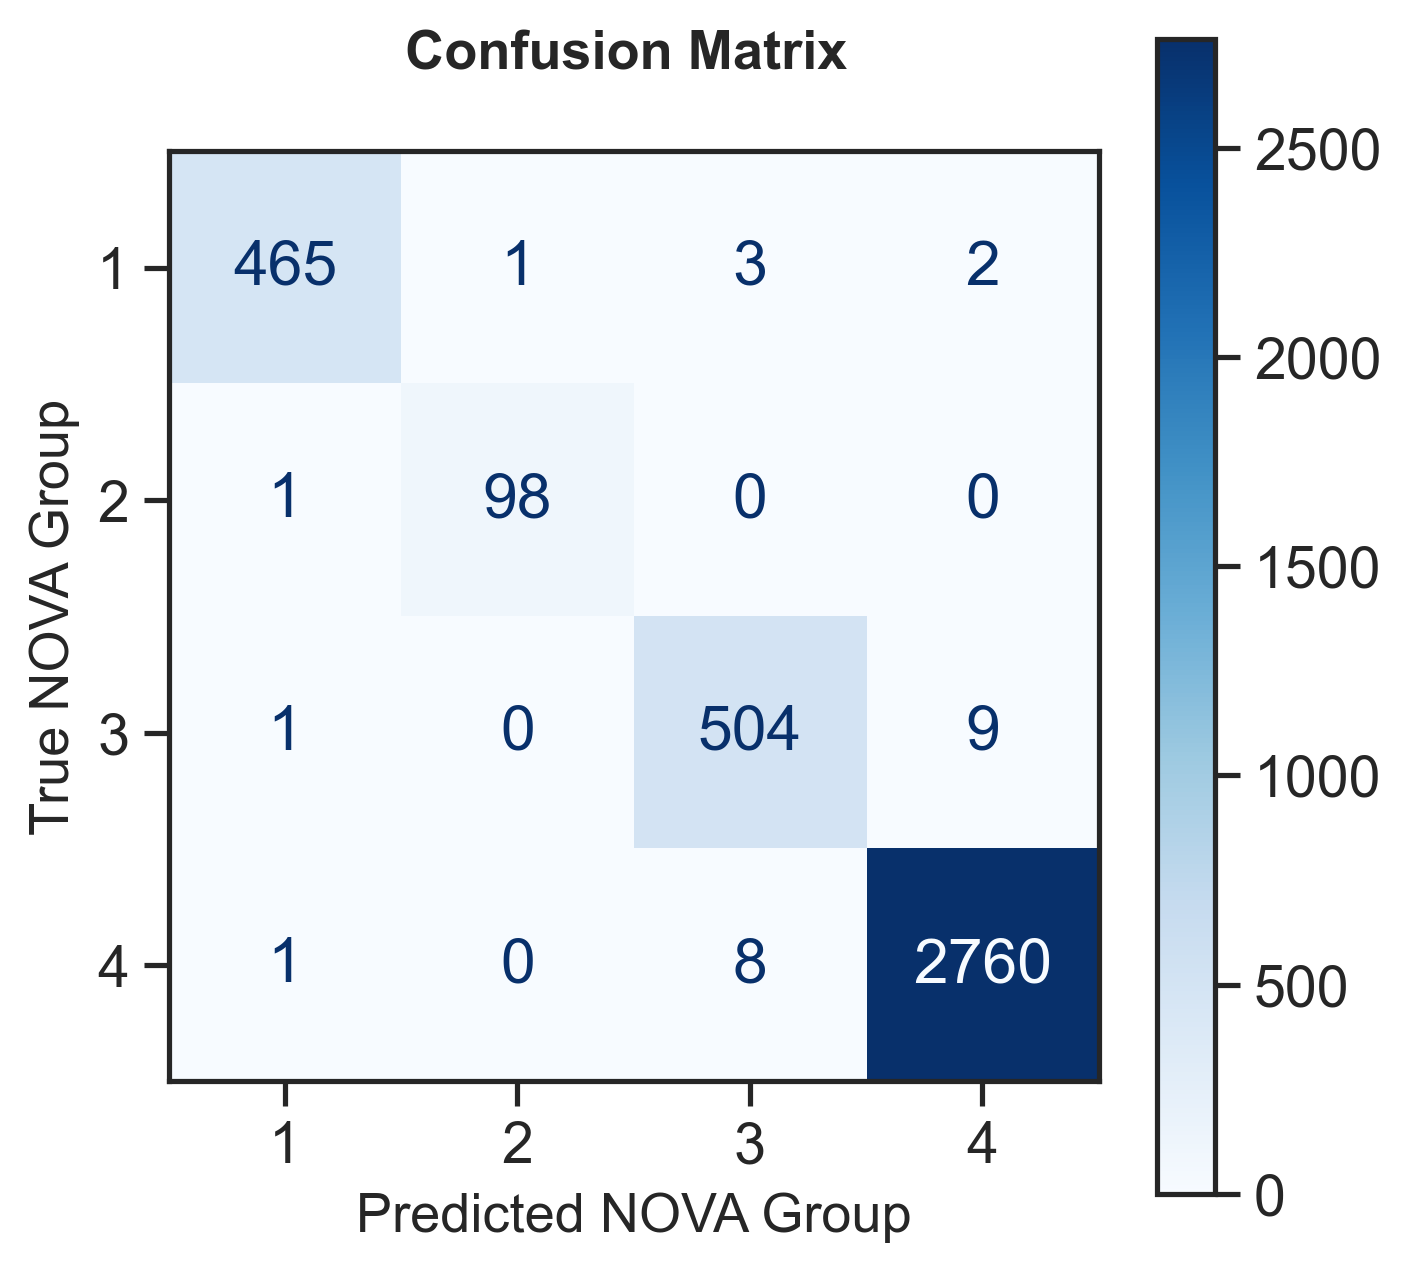

In [12]:
### Confusion Matrix
plt.rcParams['figure.dpi'] = 300
sns.set(rc={'figure.figsize':(5,5)}, style='ticks', font="Arial", font_scale=1.25)
plt.figure()

title  = "Confusion Matrix \n "
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['1','2','3','4'])

disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title(title, fontsize=13,fontweight="bold") # ,
disp.ax_.set_xlabel('Predicted NOVA Group', fontsize=13)
disp.ax_.set_ylabel('True NOVA Group', fontsize=13)
print(title)
print(disp.confusion_matrix)

C:\Users\huguanla\AppData\Local\Temp\ipykernel_15724\3194612985.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  normed_c = (c.T / c.astype(np.float).sum(axis=1)).T


Text(0, 0.5, 'True NOVA Group')

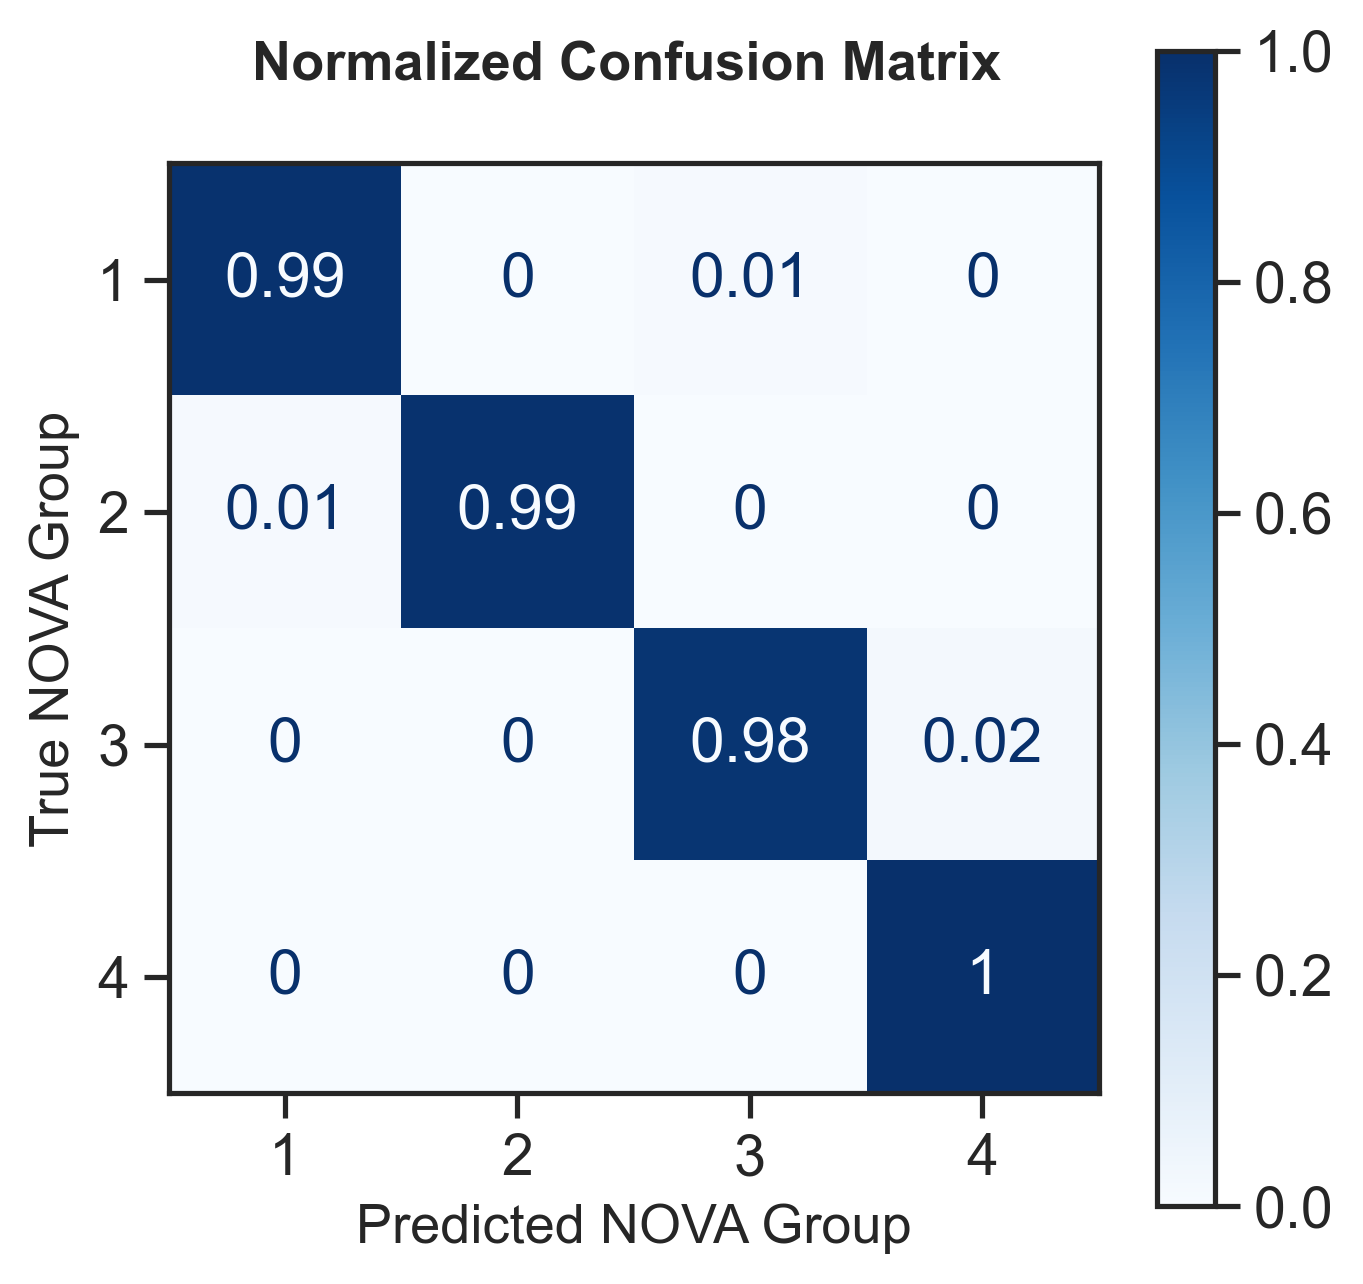

In [13]:
### normalized Confusion Matrix
c = disp.confusion_matrix
normed_c = (c.T / c.astype(np.float).sum(axis=1)).T
normed_c
normed_c=np.round(normed_c,2) # change digits to 2

title  = "Normalized Confusion Matrix \n "
disp2 = ConfusionMatrixDisplay(normed_c,
                              display_labels=['1','2','3','4'])

disp2.plot(cmap=plt.cm.Blues)
disp2.ax_.set_title(title, fontsize=13,fontweight="bold") # ,
disp2.ax_.set_xlabel('Predicted NOVA Group', fontsize=13)
disp2.ax_.set_ylabel('True NOVA Group', fontsize=13)


# Predict on new OFF data

In [ ]:
# ##### 之前训练的模型
# rfr = clf3nutri100

# dfOFF2 = dfOFF
# emb = nutrients_100_OFF # nutrient100
# dfset = "OpenFoodFact-FSANZ-nutrient100"
# print(dfset) 
# print("OpenFoodFact",df.shape,"after remove ingredient and name NA", dfOFF2.shape)

# # locations = df_o.index
# emb_o = emb.fillna(0)

# data_new = dfOFF2
# x3 = emb_o.apply(pd.to_numeric)
# y3_pred = rfr.predict(x3)
# print(y3_pred.shape)

# dfOFF2["FSANZ-hgl"]=y3_pred
# print("USDAunique-predicted-FSANZ")
# dfOFF2["FSANZ-hgl"].value_counts()
# dfOFF2.shape

In [15]:
# Read New Data USDAunique

print(dfOFF.shape)
dfOFF_NOVA = dfOFF.copy()
dfOFF_NOVA = dfOFF_NOVA.loc[:,["code","ingredients_text"]]
dfOFF_NOVA = dfOFF_NOVA.dropna(axis=0, subset=["ingredients_text"])

dfOFF_NOVA = dfOFF_NOVA
print(dfOFF_NOVA.shape)
dfOFF_NOVA = dfOFF_NOVA[['ingredients_text']]
dfOFF_NOVA.columns=['text']

dfOFF_NOVA = dfOFF_NOVA
test_df = Dataset.from_dict(dfOFF_NOVA).map(tokenize_function, batched=True)
y_pred = trainer1.predict(test_df)
predictions = tf.nn.softmax(y_pred.predictions) #, labels=clf.classes_
pred = np.argmax(predictions, 1)

dfOFF_NOVA["NOVA-hgl"]=pred+1
dfOFF_NOVA

(105185, 23)
(105185, 2)


The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 105185
  Batch size = 8
100%|██████████| 13149/13149 [04:50<00:00, 45.28it/s]


,text,NOVA-hgl
0,"Egg pasta (refined durum semolina wheat flour,...",3
1,"Wheat, rye, triticale, oat, corn, barley, soy ...",4
2,Fresh organic carrots,1
3,INGREDIENTS : LAITUE. VINAIGRETTE (HUILE DE CA...,4
4,"Ingrédients : Pâte (farine, margarines d'huile...",4
...,...,...
105180,"Chipotle peppers, water, vinegar, tomatoes, on...",3
105181,"Tomato, black gram, water, milk cream, cottons...",3
105182,"Jus d'orange (dont pulpe 1,6%), jus de clément...",1
105183,Cassava.,1


<AxesSubplot: xlabel='NOVA-hgl', ylabel='Count'>

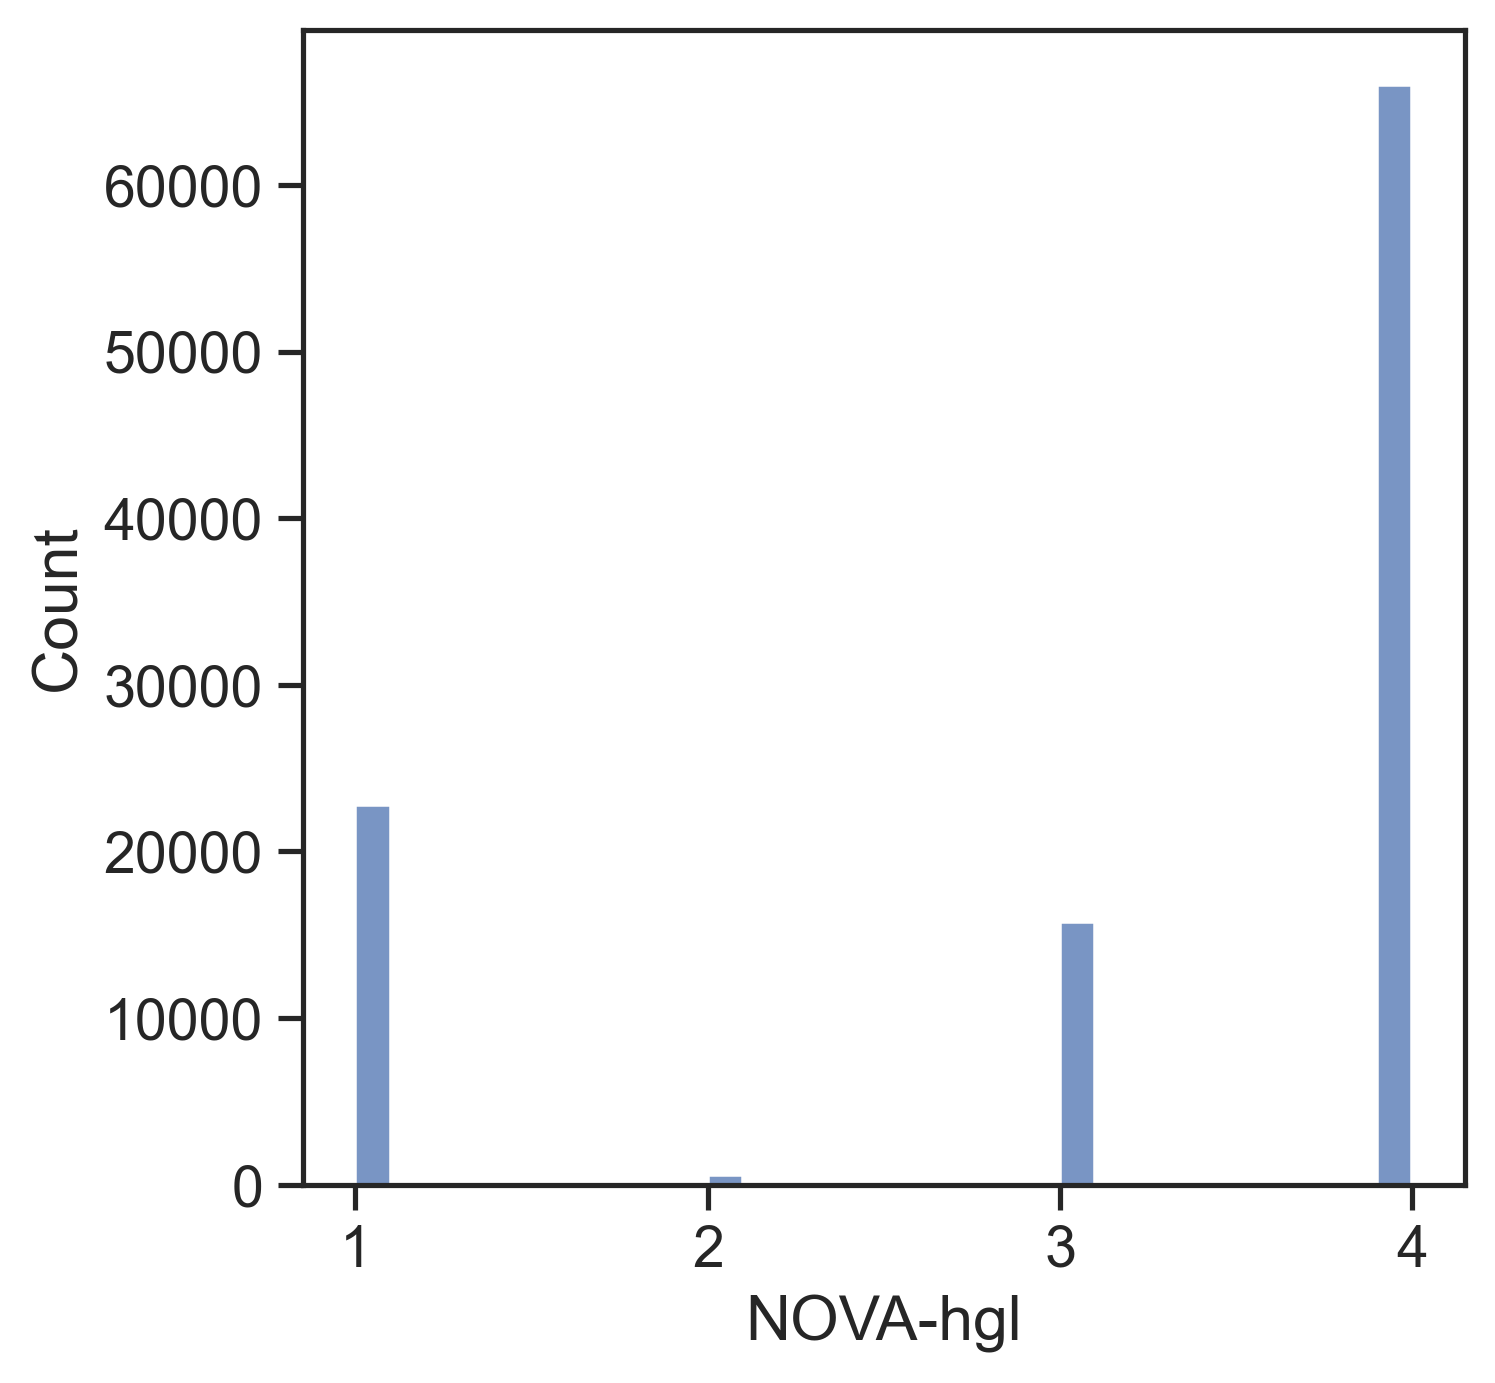

In [16]:
sns.histplot(data=dfOFF_NOVA, x="NOVA-hgl", bins=30)

In [ ]:
dfOFF_NOVA_ok = pd.concat([dfOFF, dfOFF_NOVA[['NOVA-hgl']]], axis=1)
dfOFF_NOVA_ok

,Unnamed: 0,code,product_name,brands,country,ingredients_text,additives,nutrition_grade_fr,energy,fat,...,proteins,salt,sodium,nutrition-score-fr,serving_size_numeric,serving_size_units,KCAL,NAsodium,FSANZ-hgl,NOVA-hgl
0,67,32117,Tricolor Tortellini,Napoleon,United States,"Egg pasta (refined durum semolina wheat flour,...",0.0,c,1611.0,9.23,...,13.85,1.13284,0.446000,7.0,65.0,g,385.406699,446.000000,-4.089640,3
1,72,33060,10-Grain Pancake Mix,Bob's Red Mill,United States,"Wheat, rye, triticale, oat, corn, barley, soy ...",2.0,c,1297.0,1.72,...,13.79,2.75844,1.086000,9.0,58.0,g,310.287081,1086.000000,-8.053166,4
2,175,69601,Fresh Organic Carrots,Bunny-Luv,United States,Fresh organic carrots,0.0,a,159.0,0.00,...,1.28,0.19558,0.077000,-2.0,78.0,g,38.038278,77.000000,-9.774875,1
3,176,290616,Salade Cesar,Kirkland Signature,Canada,INGREDIENTS : LAITUE. VINAIGRETTE (HUILE DE CA...,0.0,c,1210.0,12.00,...,22.00,2.16000,0.850000,6.0,100.0,g,289.473684,850.000000,1.966481,4
4,182,1938067,Chaussons tressés aux pommes,Kirkland Signature,Canada,"Ingrédients : Pâte (farine, margarines d'huile...",5.0,c,1090.0,10.70,...,3.33,0.64700,0.255000,9.0,150.0,g,260.765550,255.000000,4.214868,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105180,355883,95656335,Chipotle Peppers In Adobo Sauce,La Costena,United States,"Chipotle peppers, water, vinegar, tomatoes, on...",0.0,c,280.0,0.00,...,0.00,3.21818,1.267000,6.0,30.0,g,66.985646,1267.000000,-13.900986,3
105181,355884,95659305,Dal Makhani,Truly Indian,United States,"Tomato, black gram, water, milk cream, cottons...",0.0,b,502.0,5.33,...,4.67,1.37160,0.540000,2.0,150.0,g,120.095694,540.000000,-6.750500,3
105182,355888,9577283844672,100% Pur Jus 4 agrumes,Cora,France,"Jus d'orange (dont pulpe 1,6%), jus de clément...",0.0,c,192.0,0.50,...,0.60,0.03000,0.011811,4.0,200.0,ml,45.933014,11.811024,-3.312844,1
105183,355985,9787461062105,Natural Cassava,Industria De Casabe Paul,United States,Cassava.,0.0,a,1477.0,0.00,...,1.18,0.03048,0.012000,-1.0,85.0,g,353.349282,12.000000,-3.944408,1


In [ ]:

dfOFF_NOVA_ok.to_csv("/Users/hgl/Dropbox/545_Group_Project/545_Group_project_shared/data/food_fact_withUnhealthScore_withNOVA.csv", index=False)
